In [1]:
# G-NLL Baseline Analysis Notebook
# This notebook analyzes the G-NLL (Greedy Negative Log-Likelihood) baseline results
# Includes: AUROC analysis, ROC curves, sample answers, ROUGE scores, and LLM judge metrics

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
import os
import glob
from pathlib import Path
import json
from tqdm import tqdm

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## Configuration

Set the paths to your validation_generations.pkl files. You can either:
1. Use the latest run automatically
2. Specify a specific run directory
3. Provide a direct path to the pickle file


In [14]:
# Option 3: Direct paths (uncomment and set)
short_pickle_path = r"C:\Users\nikos\PycharmProjects\nllSAR\src\boldis\uncertainty\wandb\run-20251121_142824-wo7cdccl\files\validation_generations.pkl"

# ⭐ UPDATED: Using judge-corrected pickle for long answers
long_pickle_path = r"C:\Users\nikos\PycharmProjects\nllSAR\src\boldis\uncertainty\wandb\run-20251121_190025-5qvhbs97\files\validation_generations_judge_corrected.pkl"


# ROUGE threshold for correctness (for short answers)
ROUGE_THRESHOLD = 0.3


## Core Functions

All functions from `run_gnll_baseline.py` for computing AUROC and analyzing results.


In [15]:
def compute_gnll_auroc(pickle_path, use_rouge=False, rouge_threshold=0.3, return_details=False):
    """
    Compute AUROC for G-NLL baseline.
    
    Args:
        pickle_path: Path to validation_generations.pkl
        use_rouge: If True, use ROUGE scores for correctness (for short answers)
                   If False, use LLM judge accuracy (for long answers)
        rouge_threshold: ROUGE-L threshold for correctness (if use_rouge=True)
        return_details: If True, return detailed data including all examples
    
    Returns:
        Dictionary with results, and optionally detailed data
    """
    print(f"\n{'='*80}")
    print(f"Computing G-NLL AUROC...")
    print(f"{'='*80}")
    print(f"Loading generations from: {pickle_path}")
    
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
    
    print(f"Loaded {len(data)} examples")
    
    y_true = []
    gnll_uncertainties = []
    example_ids = []
    responses = []
    rouge_scores = []
    judge_accuracies = []
    questions = []
    references = []
    
    if use_rouge:
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        print(f"Using ROUGE-L threshold: {rouge_threshold}")
    else:
        print("Using LLM judge accuracy (from 'accuracy' field)")
    
    for example_id, entry in data.items():
        if 'most_likely_answer' not in entry:
            continue
            
        mla = entry['most_likely_answer']
        pred_answer = mla.get('response', '').strip()
        
        if use_rouge:
            # Use ROUGE score for correctness
            if 'reference' in entry and 'answers' in entry['reference']:
                true_answers = entry['reference']['answers']['text']
                best_rougeL = 0.0
                best_rouge1 = 0.0
                best_rouge2 = 0.0
                for ref in true_answers:
                    score = scorer.score(ref.strip(), pred_answer)
                    best_rougeL = max(best_rougeL, score['rougeL'].fmeasure)
                    best_rouge1 = max(best_rouge1, score['rouge1'].fmeasure)
                    best_rouge2 = max(best_rouge2, score['rouge2'].fmeasure)
                is_correct = int(best_rougeL >= rouge_threshold)
                rouge_scores.append({
                    'rouge1': best_rouge1,
                    'rouge2': best_rouge2,
                    'rougeL': best_rougeL
                })
            else:
                continue
        else:
            # Use LLM judge accuracy
            judge_acc = mla.get('accuracy', 0.0)
            is_correct = int(judge_acc > 0.5)
            judge_accuracies.append(judge_acc)
            rouge_scores.append(None)
        
        # Compute G-NLL (sum of token log-probs, negated)
        if 'token_log_likelihoods' in mla:
            token_log_likelihoods = mla['token_log_likelihoods']
            sequence_nll = -sum(token_log_likelihoods)  # Negative log likelihood
            gnll_uncertainties.append(sequence_nll)
            y_true.append(is_correct)
            example_ids.append(example_id)
            responses.append(pred_answer)
            questions.append(entry.get('question', ''))
            if 'reference' in entry and 'answers' in entry['reference']:
                references.append(entry['reference']['answers']['text'])
            else:
                references.append([])
        else:
            print(f"Warning: No token_log_likelihoods for example {example_id}")
    
    if len(y_true) == 0:
        print("❌ No valid examples found!")
        return None
    
    # Compute AUROC
    try:
        # For AUROC, higher uncertainty (higher NLL) should predict incorrect answers
        # roc_auc_score expects higher scores to predict positive class (correct=1)
        # So we negate G-NLL: higher confidence (lower NLL) should predict correct answers
        auroc = roc_auc_score(y_true, -np.array(gnll_uncertainties))
        
        # Also compute ROC curve for visualization
        fpr, tpr, thresholds = roc_curve(y_true, -np.array(gnll_uncertainties))
        
        accuracy = sum(y_true) / len(y_true) if len(y_true) > 0 else 0
        
        results = {
            'G-NLL_AUROC': auroc,
            'Accuracy': accuracy,
            'Num_examples': len(y_true),
            'Num_correct': int(sum(y_true)),
            'Num_incorrect': int(len(y_true) - sum(y_true)),
            'Mean_G-NLL': np.mean(gnll_uncertainties),
            'Std_G-NLL': np.std(gnll_uncertainties),
            'Min_G-NLL': np.min(gnll_uncertainties),
            'Max_G-NLL': np.max(gnll_uncertainties),
            'ROC_curve': {
                'fpr': fpr,
                'tpr': tpr,
                'thresholds': thresholds
            }
        }
        
        print(f"\nResults:")
        print(f"  G-NLL AUROC: {auroc:.4f}")
        print(f"  Accuracy: {accuracy:.4f} ({int(sum(y_true))}/{len(y_true)})")
        print(f"  Number of examples: {len(y_true)}")
        print(f"  Mean G-NLL: {np.mean(gnll_uncertainties):.4f}")
        print(f"  Std G-NLL: {np.std(gnll_uncertainties):.4f}")
        print(f"  Min G-NLL: {np.min(gnll_uncertainties):.4f}")
        print(f"  Max G-NLL: {np.max(gnll_uncertainties):.4f}")
        
        if return_details:
            details = {
                'example_ids': example_ids,
                'y_true': y_true,
                'gnll_uncertainties': gnll_uncertainties,
                'responses': responses,
                'questions': questions,
                'references': references,
                'rouge_scores': rouge_scores,
                'judge_accuracies': judge_accuracies if not use_rouge else None
            }
            return results, details
        else:
            return results
        
    except ValueError as e:
        print(f"❌ Error computing AUROC: {e}")
        print(f"This might happen if all labels are the same (all correct or all incorrect)")
        return None


In [16]:
# Analyze short answers (if available)
short_results_rouge = None
short_results_judge = None
short_details_rouge = None
short_details_judge = None

if short_pickle_path and os.path.exists(short_pickle_path):
    print("="*80)
    print("ANALYZING SHORT ANSWERS")
    print("="*80)
    
    # With ROUGE
    print("\n--- Short Answers: ROUGE-based correctness ---")
    result = compute_gnll_auroc(short_pickle_path, use_rouge=True, rouge_threshold=ROUGE_THRESHOLD, return_details=True)
    if result:
        short_results_rouge, short_details_rouge = result
    
    # With LLM Judge
    print("\n--- Short Answers: LLM Judge-based correctness ---")
    result = compute_gnll_auroc(short_pickle_path, use_rouge=False, return_details=True)
    if result:
        short_results_judge, short_details_judge = result
else:
    print("⚠️ Short answers pickle file not found. Set short_pickle_path manually.")


ANALYZING SHORT ANSWERS

--- Short Answers: ROUGE-based correctness ---

Computing G-NLL AUROC...
Loading generations from: C:\Users\nikos\PycharmProjects\nllSAR\src\boldis\uncertainty\wandb\run-20251121_142824-wo7cdccl\files\validation_generations.pkl
Loaded 400 examples
Using ROUGE-L threshold: 0.3

Results:
  G-NLL AUROC: 0.7274
  Accuracy: 0.7375 (295/400)
  Number of examples: 400
  Mean G-NLL: 0.8935
  Std G-NLL: 1.5701
  Min G-NLL: 0.0001
  Max G-NLL: 9.9557

--- Short Answers: LLM Judge-based correctness ---

Computing G-NLL AUROC...
Loading generations from: C:\Users\nikos\PycharmProjects\nllSAR\src\boldis\uncertainty\wandb\run-20251121_142824-wo7cdccl\files\validation_generations.pkl
Loaded 400 examples
Using LLM judge accuracy (from 'accuracy' field)

Results:
  G-NLL AUROC: 0.7321
  Accuracy: 0.7050 (282/400)
  Number of examples: 400
  Mean G-NLL: 0.8935
  Std G-NLL: 1.5701
  Min G-NLL: 0.0001
  Max G-NLL: 9.9557


In [17]:
# Analyze long answers (if available)
long_results_judge = None
long_details_judge = None

if long_pickle_path and os.path.exists(long_pickle_path):
    print("="*80)
    print("ANALYZING LONG ANSWERS")
    print("="*80)
    
    print("\n--- Long Answers: LLM Judge-based correctness ---")
    result = compute_gnll_auroc(long_pickle_path, use_rouge=False, return_details=True)
    if result:
        long_results_judge, long_details_judge = result
else:
    print("⚠️ Long answers pickle file not found. Set long_pickle_path manually.")


ANALYZING LONG ANSWERS

--- Long Answers: LLM Judge-based correctness ---

Computing G-NLL AUROC...
Loading generations from: C:\Users\nikos\PycharmProjects\nllSAR\src\boldis\uncertainty\wandb\run-20251121_190025-5qvhbs97\files\validation_generations_judge_corrected.pkl
Loaded 400 examples
Using LLM judge accuracy (from 'accuracy' field)

Results:
  G-NLL AUROC: 0.5552
  Accuracy: 0.9150 (366/400)
  Number of examples: 400
  Mean G-NLL: 16.8253
  Std G-NLL: 13.6399
  Min G-NLL: 0.1291
  Max G-NLL: 69.3667


## Visualizations

### 1. ROC Curves


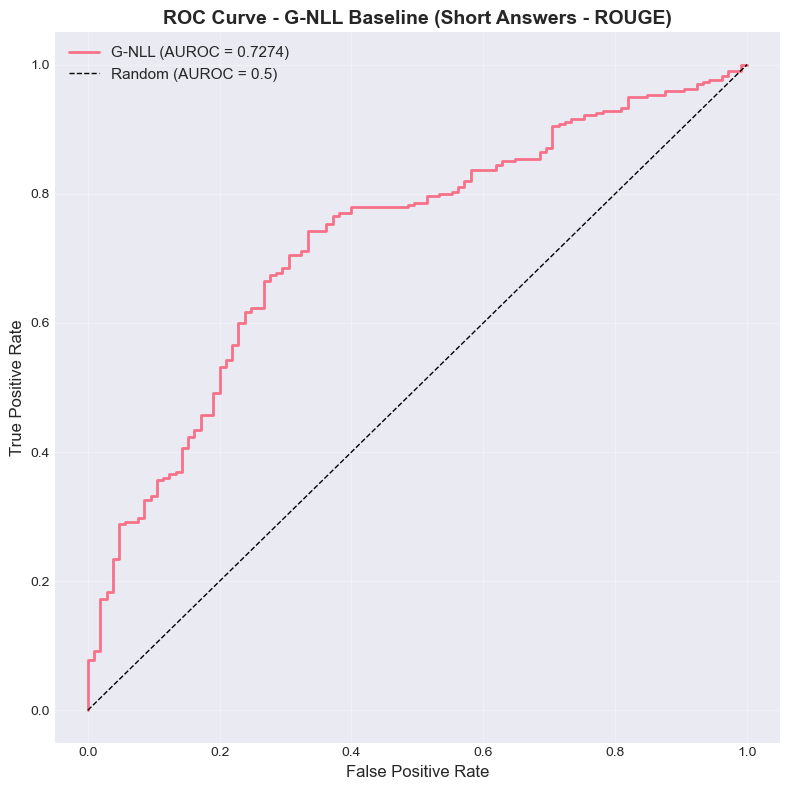

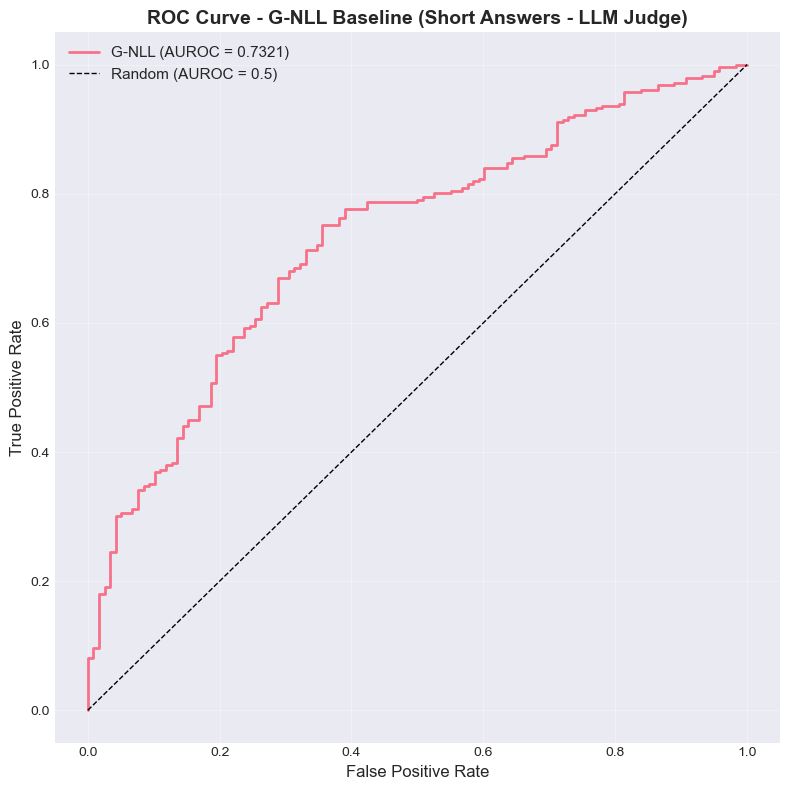

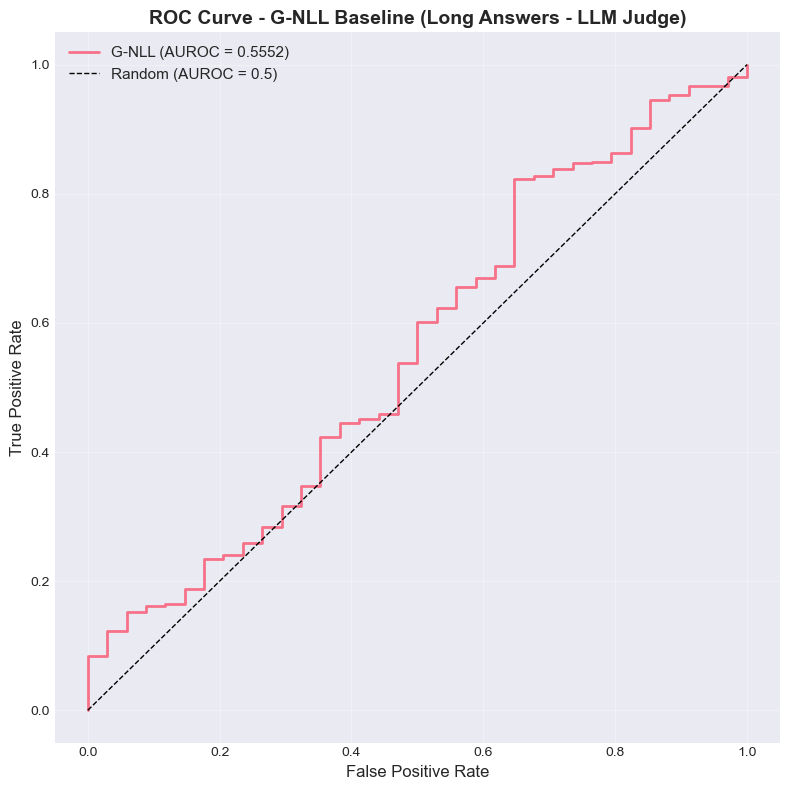

In [18]:
def plot_roc_curve(results_dict, title_suffix=""):
    """Plot ROC curve from results dictionary."""
    if not results_dict or 'ROC_curve' not in results_dict:
        print("No ROC curve data available")
        return
    
    fpr = results_dict['ROC_curve']['fpr']
    tpr = results_dict['ROC_curve']['tpr']
    auroc = results_dict['G-NLL_AUROC']
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'G-NLL (AUROC = {auroc:.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUROC = 0.5)', linewidth=1)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - G-NLL Baseline{title_suffix}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot ROC curves
if short_results_rouge:
    plot_roc_curve(short_results_rouge, " (Short Answers - ROUGE)")

if short_results_judge:
    plot_roc_curve(short_results_judge, " (Short Answers - LLM Judge)")

if long_results_judge:
    plot_roc_curve(long_results_judge, " (Long Answers - LLM Judge)")


### 2. G-NLL Distribution: Correct vs Incorrect


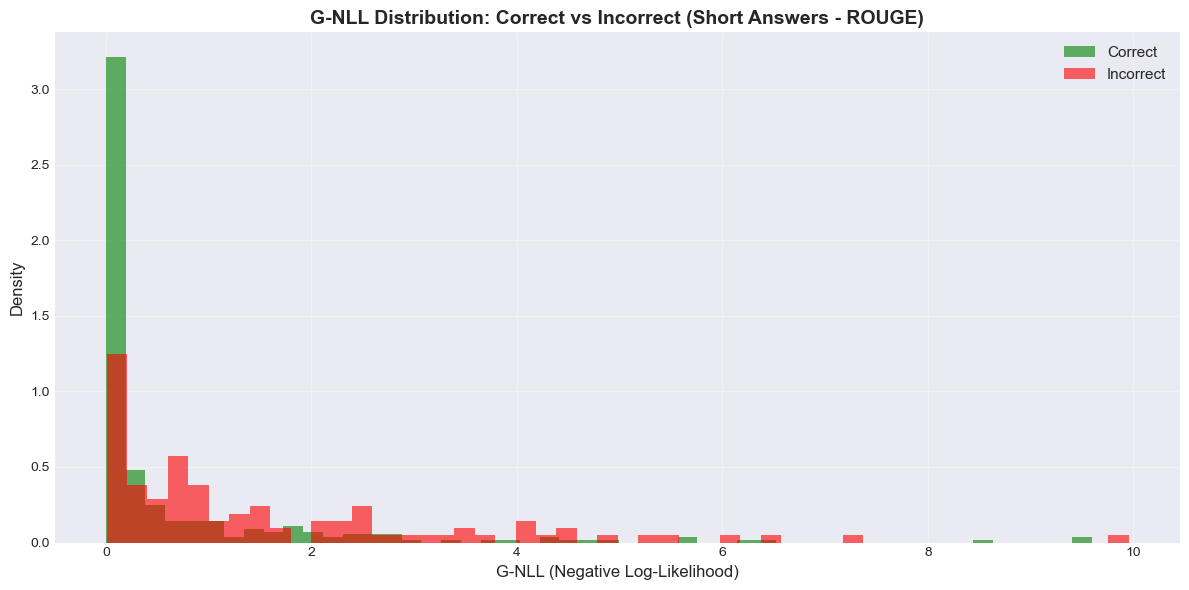


Statistics (Short Answers - ROUGE):
  Correct answers - Mean G-NLL: 0.6660, Std: 1.3991
  Incorrect answers - Mean G-NLL: 1.5329, Std: 1.8270


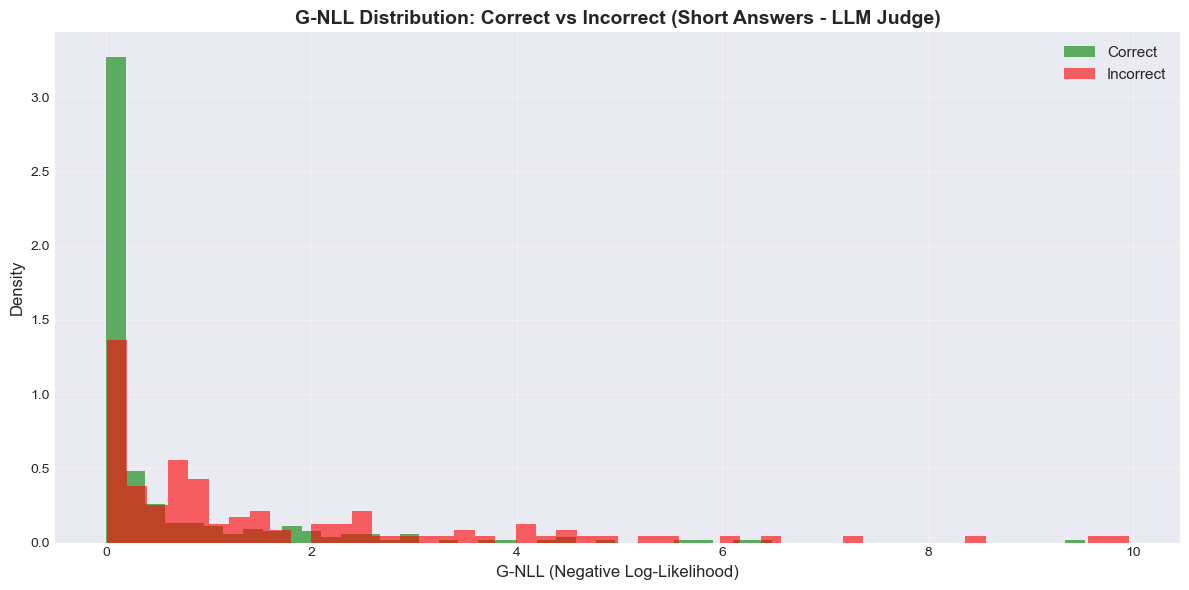


Statistics (Short Answers - LLM Judge):
  Correct answers - Mean G-NLL: 0.6038, Std: 1.2160
  Incorrect answers - Mean G-NLL: 1.5859, Std: 2.0354


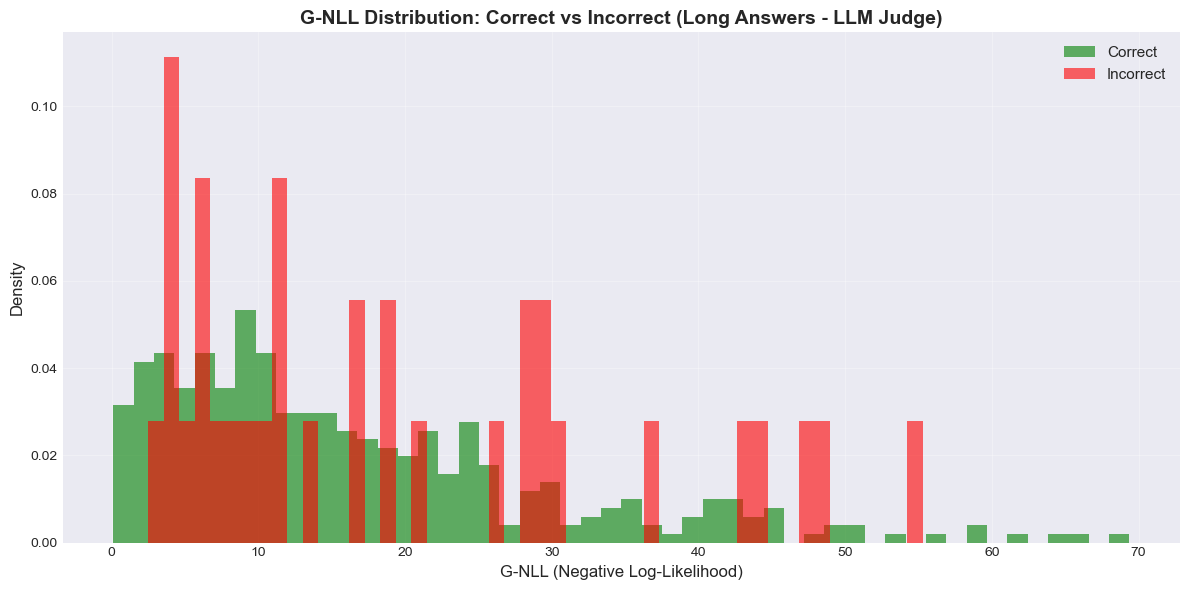


Statistics (Long Answers - LLM Judge):
  Correct answers - Mean G-NLL: 16.5671, Std: 13.4797
  Incorrect answers - Mean G-NLL: 19.6040, Std: 14.9794


In [19]:
def plot_gnll_distribution(details, title_suffix=""):
    """Plot G-NLL distribution for correct vs incorrect answers."""
    if not details:
        print("No details data available")
        return
    
    gnll = np.array(details['gnll_uncertainties'])
    y_true = np.array(details['y_true'])
    
    correct_nll = gnll[y_true == 1]
    incorrect_nll = gnll[y_true == 0]
    
    plt.figure(figsize=(12, 6))
    plt.hist(correct_nll, bins=50, alpha=0.6, label='Correct', color='green', density=True)
    plt.hist(incorrect_nll, bins=50, alpha=0.6, label='Incorrect', color='red', density=True)
    plt.xlabel('G-NLL (Negative Log-Likelihood)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title(f'G-NLL Distribution: Correct vs Incorrect{title_suffix}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nStatistics{title_suffix}:")
    print(f"  Correct answers - Mean G-NLL: {np.mean(correct_nll):.4f}, Std: {np.std(correct_nll):.4f}")
    print(f"  Incorrect answers - Mean G-NLL: {np.mean(incorrect_nll):.4f}, Std: {np.std(incorrect_nll):.4f}")

# Plot distributions
if short_details_rouge:
    plot_gnll_distribution(short_details_rouge, " (Short Answers - ROUGE)")

if short_details_judge:
    plot_gnll_distribution(short_details_judge, " (Short Answers - LLM Judge)")

if long_details_judge:
    plot_gnll_distribution(long_details_judge, " (Long Answers - LLM Judge)")


### 3. Scatter Plot: G-NLL vs Correctness


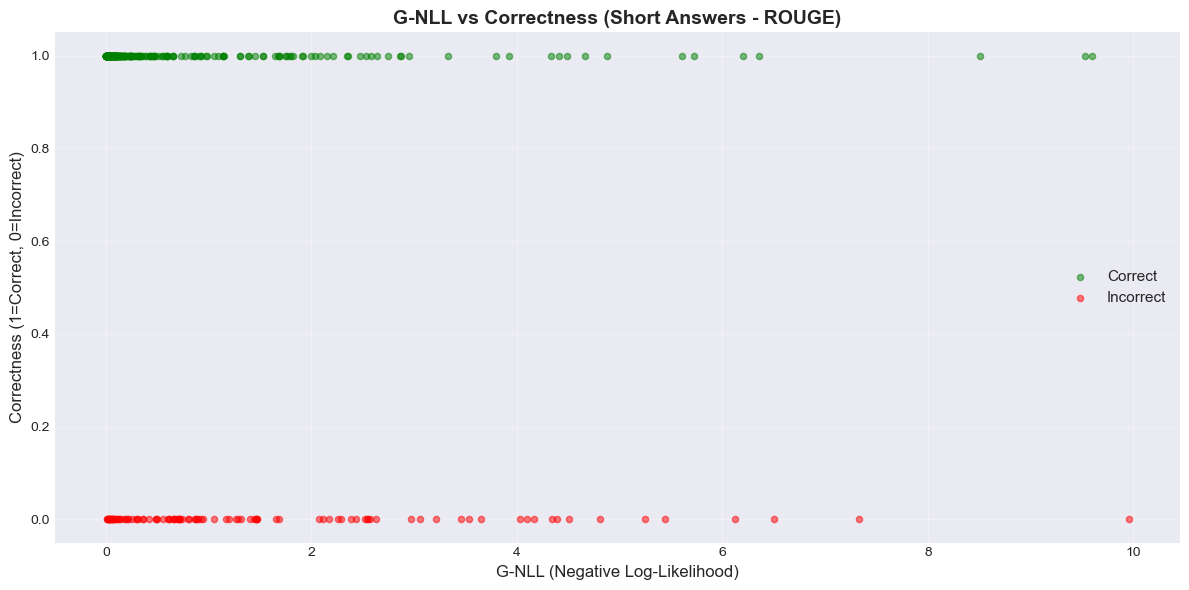

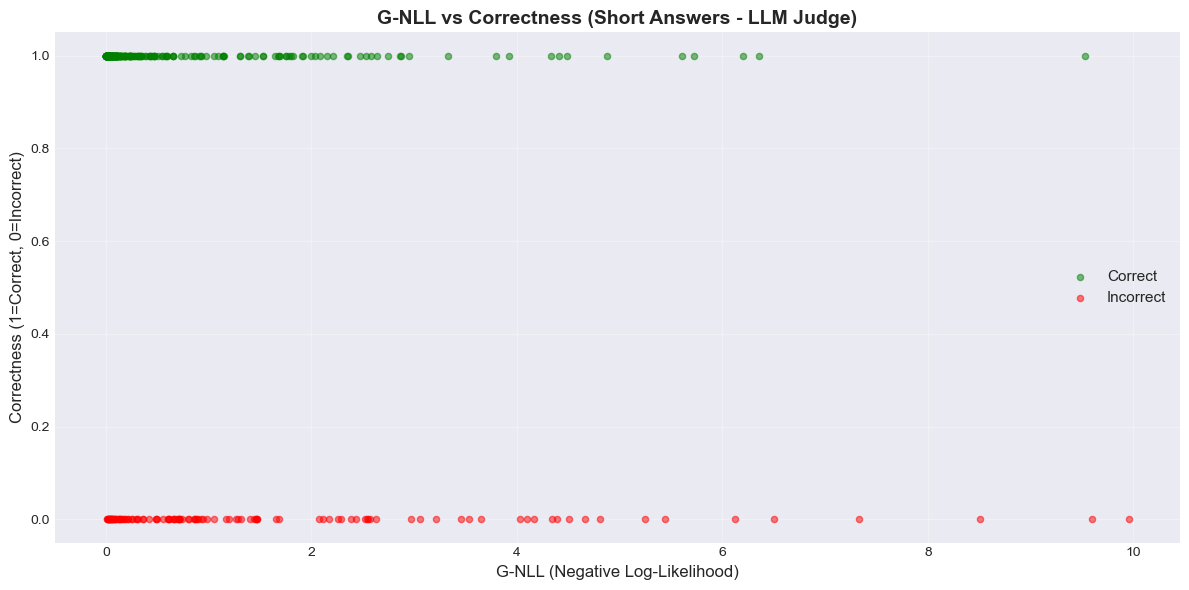

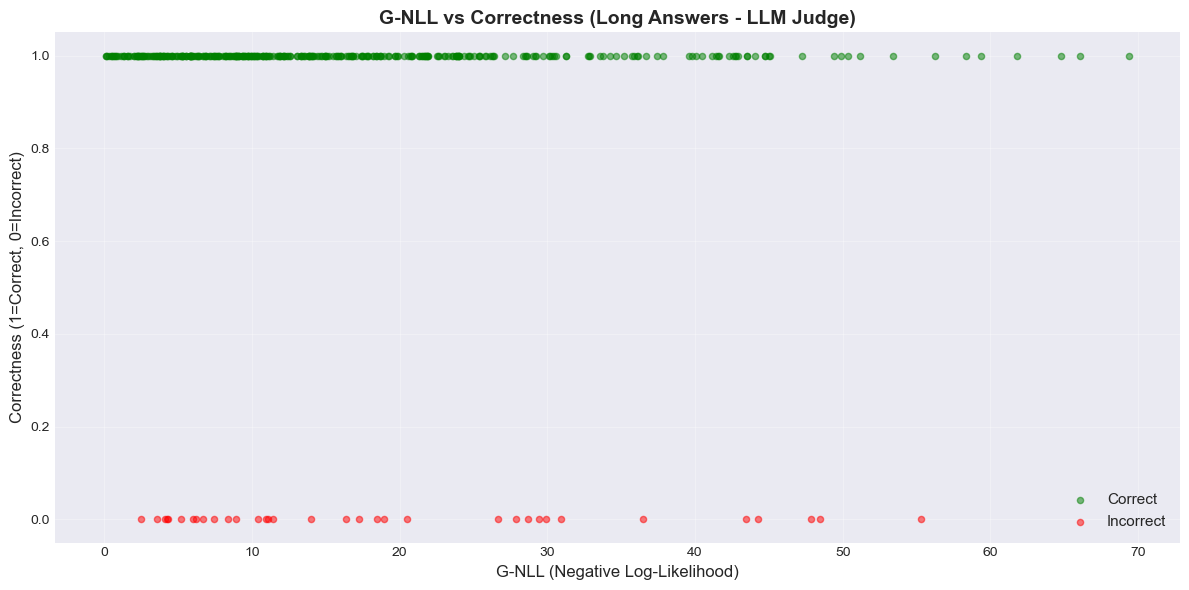

In [20]:
def plot_gnll_vs_correctness(details, title_suffix=""):
    """Plot scatter plot of G-NLL vs correctness."""
    if not details:
        print("No details data available")
        return
    
    gnll = np.array(details['gnll_uncertainties'])
    y_true = np.array(details['y_true'])
    
    plt.figure(figsize=(12, 6))
    plt.scatter(gnll[y_true == 1], y_true[y_true == 1], alpha=0.5, label='Correct', color='green', s=20)
    plt.scatter(gnll[y_true == 0], y_true[y_true == 0], alpha=0.5, label='Incorrect', color='red', s=20)
    plt.xlabel('G-NLL (Negative Log-Likelihood)', fontsize=12)
    plt.ylabel('Correctness (1=Correct, 0=Incorrect)', fontsize=12)
    plt.title(f'G-NLL vs Correctness{title_suffix}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot scatter plots
if short_details_rouge:
    plot_gnll_vs_correctness(short_details_rouge, " (Short Answers - ROUGE)")

if short_details_judge:
    plot_gnll_vs_correctness(short_details_judge, " (Short Answers - LLM Judge)")

if long_details_judge:
    plot_gnll_vs_correctness(long_details_judge, " (Long Answers - LLM Judge)")


### 4. ROUGE Scores Analysis (Short Answers Only)


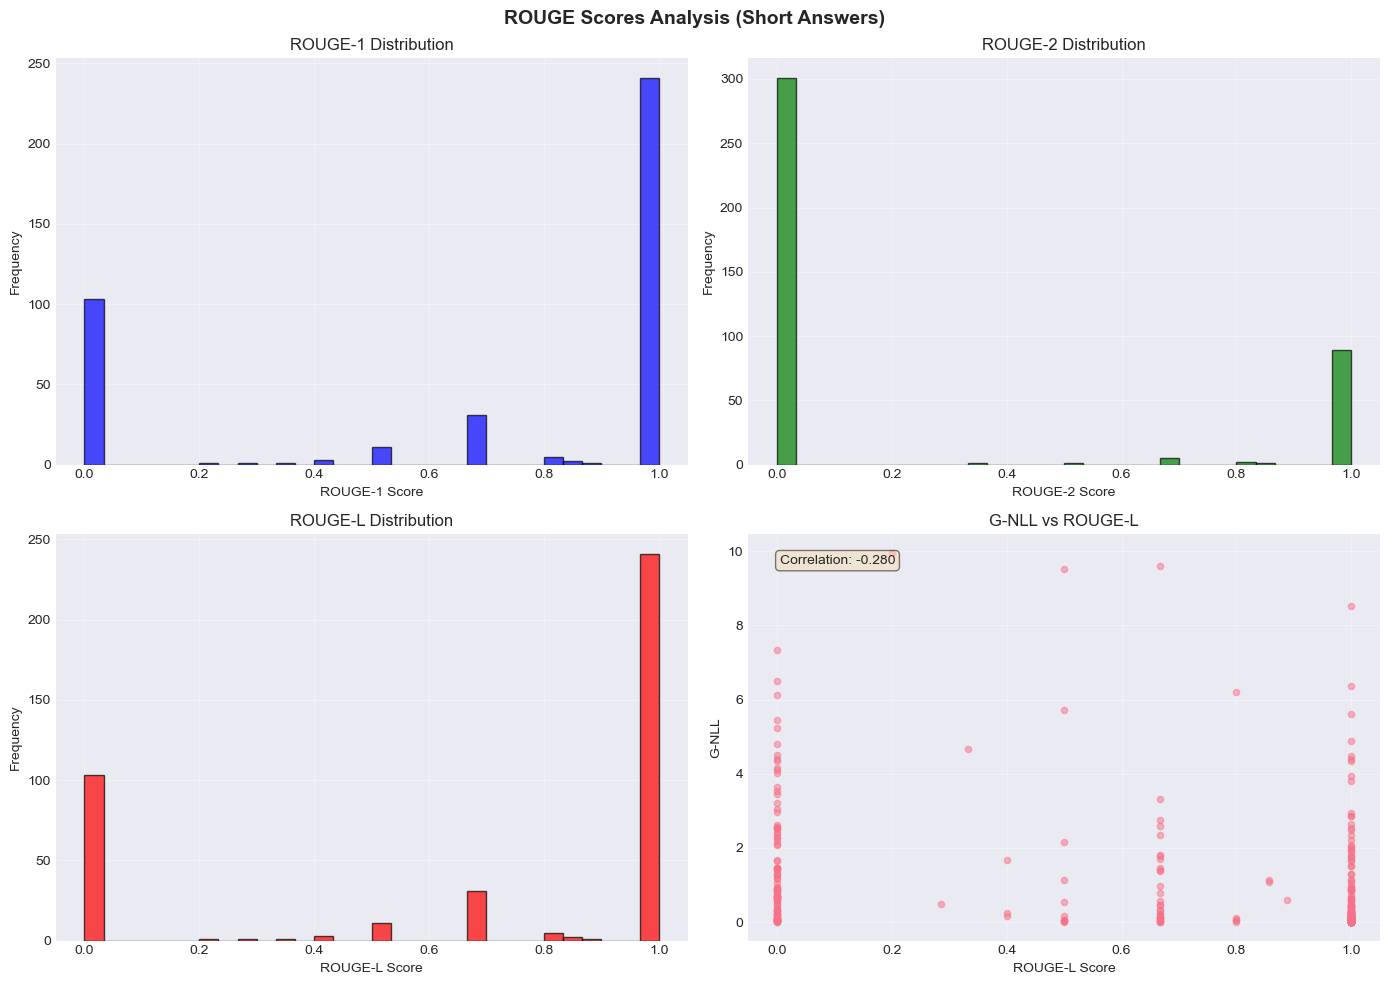


ROUGE Statistics (Short Answers):
  ROUGE-1 - Mean: 0.6895, Std: 0.4288
  ROUGE-2 - Mean: 0.2391, Std: 0.4205
  ROUGE-L - Mean: 0.6895, Std: 0.4288
  G-NLL vs ROUGE-L Correlation: -0.2798


In [21]:
def plot_rouge_scores(details, title_suffix=""):
    """Plot ROUGE score distributions and correlations with G-NLL."""
    if not details or not details['rouge_scores']:
        print("No ROUGE scores available")
        return
    
    rouge_scores = details['rouge_scores']
    gnll = np.array(details['gnll_uncertainties'])
    
    rouge1 = [r['rouge1'] for r in rouge_scores if r]
    rouge2 = [r['rouge2'] for r in rouge_scores if r]
    rougeL = [r['rougeL'] for r in rouge_scores if r]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # ROUGE score distributions
    axes[0, 0].hist(rouge1, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_xlabel('ROUGE-1 Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('ROUGE-1 Distribution')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].hist(rouge2, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_xlabel('ROUGE-2 Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('ROUGE-2 Distribution')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].hist(rougeL, bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[1, 0].set_xlabel('ROUGE-L Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('ROUGE-L Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # G-NLL vs ROUGE-L scatter
    axes[1, 1].scatter(rougeL, gnll[:len(rougeL)], alpha=0.5, s=20)
    axes[1, 1].set_xlabel('ROUGE-L Score')
    axes[1, 1].set_ylabel('G-NLL')
    axes[1, 1].set_title('G-NLL vs ROUGE-L')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Calculate correlation
    if len(rougeL) > 0:
        correlation = np.corrcoef(rougeL, gnll[:len(rougeL)])[0, 1]
        axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                       transform=axes[1, 1].transAxes, 
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'ROUGE Scores Analysis{title_suffix}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nROUGE Statistics{title_suffix}:")
    print(f"  ROUGE-1 - Mean: {np.mean(rouge1):.4f}, Std: {np.std(rouge1):.4f}")
    print(f"  ROUGE-2 - Mean: {np.mean(rouge2):.4f}, Std: {np.std(rouge2):.4f}")
    print(f"  ROUGE-L - Mean: {np.mean(rougeL):.4f}, Std: {np.std(rougeL):.4f}")
    if len(rougeL) > 0:
        print(f"  G-NLL vs ROUGE-L Correlation: {correlation:.4f}")

if short_details_rouge:
    plot_rouge_scores(short_details_rouge, " (Short Answers)")


### 5. LLM Judge Accuracy Analysis


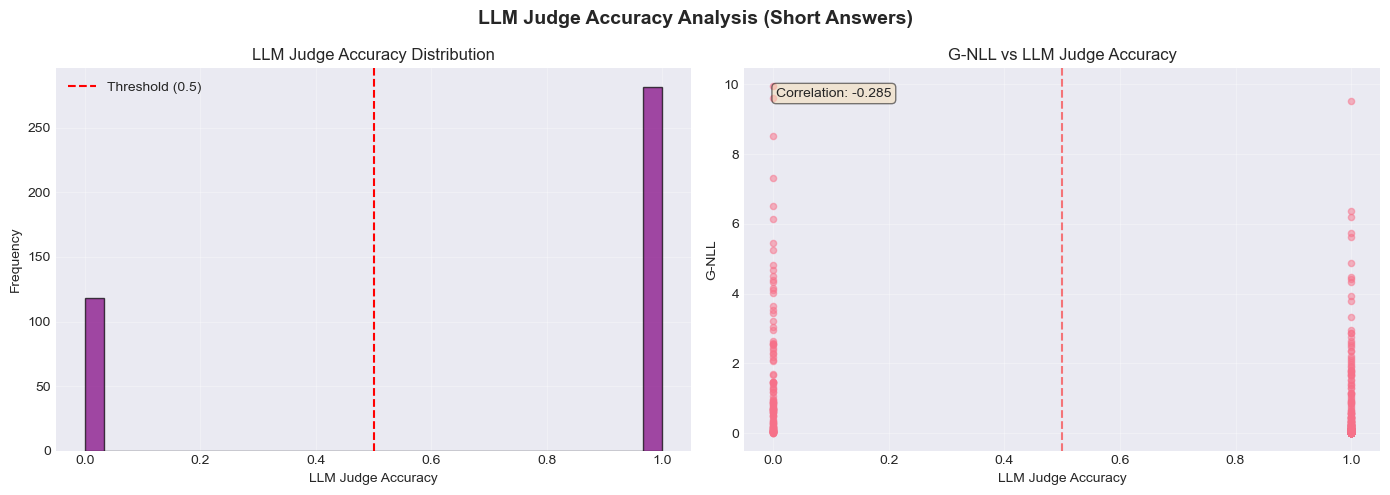


LLM Judge Statistics (Short Answers):
  Mean Accuracy: 0.7050, Std: 0.4560
  Min Accuracy: 0.0000, Max: 1.0000
  G-NLL vs Judge Accuracy Correlation: -0.2853


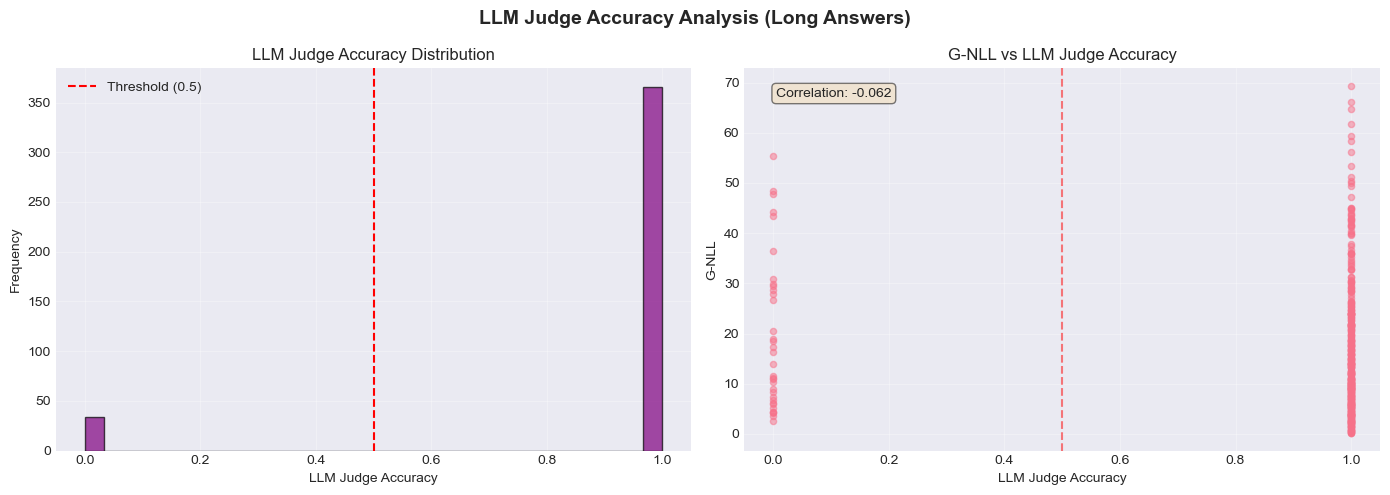


LLM Judge Statistics (Long Answers):
  Mean Accuracy: 0.9150, Std: 0.2789
  Min Accuracy: 0.0000, Max: 1.0000
  G-NLL vs Judge Accuracy Correlation: -0.0621


In [22]:
def plot_judge_accuracy(details, title_suffix=""):
    """Plot LLM judge accuracy distributions and correlations with G-NLL."""
    if not details or details['judge_accuracies'] is None:
        print("No LLM judge accuracy data available")
        return
    
    judge_acc = np.array(details['judge_accuracies'])
    gnll = np.array(details['gnll_uncertainties'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Judge accuracy distribution
    axes[0].hist(judge_acc, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[0].set_xlabel('LLM Judge Accuracy')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('LLM Judge Accuracy Distribution')
    axes[0].axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # G-NLL vs Judge Accuracy scatter
    axes[1].scatter(judge_acc, gnll, alpha=0.5, s=20)
    axes[1].set_xlabel('LLM Judge Accuracy')
    axes[1].set_ylabel('G-NLL')
    axes[1].set_title('G-NLL vs LLM Judge Accuracy')
    axes[1].axvline(0.5, color='red', linestyle='--', alpha=0.5)
    axes[1].grid(True, alpha=0.3)
    
    # Calculate correlation
    correlation = np.corrcoef(judge_acc, gnll)[0, 1]
    axes[1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=axes[1].transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'LLM Judge Accuracy Analysis{title_suffix}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nLLM Judge Statistics{title_suffix}:")
    print(f"  Mean Accuracy: {np.mean(judge_acc):.4f}, Std: {np.std(judge_acc):.4f}")
    print(f"  Min Accuracy: {np.min(judge_acc):.4f}, Max: {np.max(judge_acc):.4f}")
    print(f"  G-NLL vs Judge Accuracy Correlation: {correlation:.4f}")

if short_details_judge:
    plot_judge_accuracy(short_details_judge, " (Short Answers)")

if long_details_judge:
    plot_judge_accuracy(long_details_judge, " (Long Answers)")


## Sample Answers Display

Display sample questions, answers, and metrics.


In [23]:
def display_sample_answers(details, results, num_samples=10, use_rouge=False, title_suffix="", 
                          show_extremes=False):
    """Display sample questions, answers, and metrics."""
    if not details:
        print("No details data available")
        return
    
    gnll = np.array(details['gnll_uncertainties'])
    
    # If show_extremes, show highest and lowest G-NLL examples
    if show_extremes and len(gnll) > 0:
        indices = []
        # Highest G-NLL (most uncertain)
        highest_indices = np.argsort(gnll)[-num_samples//2:][::-1]
        # Lowest G-NLL (most confident)
        lowest_indices = np.argsort(gnll)[:num_samples//2]
        indices = list(lowest_indices) + list(highest_indices)
    else:
        indices = list(range(min(num_samples, len(details['questions']))))
    
    print(f"\n{'='*80}")
    print(f"Sample Answers{title_suffix}")
    if show_extremes:
        print("(Showing examples with lowest and highest G-NLL)")
    print(f"{'='*80}")
    print(f"Showing {len(indices)} examples (out of {len(details['questions'])})")
    print(f"Overall AUROC: {results['G-NLL_AUROC']:.4f}, Accuracy: {results['Accuracy']:.4f}")
    print(f"{'='*80}\n")
    
    # Display in a more readable format
    for i, idx in enumerate(indices):
        label = "Lowest G-NLL" if i < len(indices)//2 else "Highest G-NLL"
        print(f"\n--- Example {i + 1} ({label}) ---")
        print(f"Question: {details['questions'][idx][:200]}...")
        print(f"Response: {details['responses'][idx][:200]}...")
        print(f"G-NLL: {gnll[idx]:.4f}")
        print(f"Correct: {'✓' if details['y_true'][idx] == 1 else '✗'}")
        
        if use_rouge and details['rouge_scores'] and details['rouge_scores'][idx]:
            r = details['rouge_scores'][idx]
            print(f"ROUGE-1: {r['rouge1']:.3f}, ROUGE-2: {r['rouge2']:.3f}, ROUGE-L: {r['rougeL']:.3f}")
            if details['references'] and details['references'][idx]:
                ref = details['references'][idx][0]
                print(f"Reference: {ref[:150]}..." if len(ref) > 150 else f"Reference: {ref}")
        elif details['judge_accuracies'] and details['judge_accuracies'][idx] is not None:
            print(f"Judge Accuracy: {details['judge_accuracies'][idx]:.3f}")
        print()

# Display samples
if short_details_rouge and short_results_rouge:
    display_sample_answers(short_details_rouge, short_results_rouge, num_samples=5, 
                          use_rouge=True, title_suffix=" (Short Answers - ROUGE)")

if short_details_judge and short_results_judge:
    display_sample_answers(short_details_judge, short_results_judge, num_samples=5, 
                          use_rouge=False, title_suffix=" (Short Answers - LLM Judge)")

if long_details_judge and long_results_judge:
    display_sample_answers(long_details_judge, long_results_judge, num_samples=5, 
                          use_rouge=False, title_suffix=" (Long Answers - LLM Judge)")



Sample Answers (Short Answers - ROUGE)
Showing 5 examples (out of 400)
Overall AUROC: 0.7274, Accuracy: 0.7375


--- Example 1 (Lowest G-NLL) ---
Question: Who's missing: Miss Scarlett, Mrs. White, Mr. Green, Mrs. Peacock, Professor Plum?...
Response: mr. green, mr. plum, miss scarlett, miss white...
G-NLL: 9.9557
Correct: ✗
ROUGE-1: 0.200, ROUGE-2: 0.000, ROUGE-L: 0.200
Reference: miss scarlet


--- Example 2 (Lowest G-NLL) ---
Question: What was the former name of Manchester airport ?...
Response: ringway...
G-NLL: 0.0096
Correct: ✓
ROUGE-1: 1.000, ROUGE-2: 0.000, ROUGE-L: 1.000
Reference: ringway


--- Example 3 (Highest G-NLL) ---
Question: Name either of the detectives featured in novels by Reginald Hill and in a TV series based on the novels?...
Response: dalziel and pascoe...
G-NLL: 0.0986
Correct: ✓
ROUGE-1: 1.000, ROUGE-2: 1.000, ROUGE-L: 1.000
Reference: dalziel and pascoe


--- Example 4 (Highest G-NLL) ---
Question: Which US gangster was released from Alcatraz prison in No

### Examples with Extreme G-NLL Values

Show examples with the lowest (most confident) and highest (most uncertain) G-NLL values.


In [24]:
# Display extreme examples
if short_details_rouge and short_results_rouge:
    display_sample_answers(short_details_rouge, short_results_rouge, num_samples=6, 
                          use_rouge=True, title_suffix=" (Short Answers - ROUGE)", 
                          show_extremes=True)

if short_details_judge and short_results_judge:
    display_sample_answers(short_details_judge, short_results_judge, num_samples=6, 
                          use_rouge=False, title_suffix=" (Short Answers - LLM Judge)",
                          show_extremes=True)

if long_details_judge and long_results_judge:
    display_sample_answers(long_details_judge, long_results_judge, num_samples=6, 
                          use_rouge=False, title_suffix=" (Long Answers - LLM Judge)",
                          show_extremes=True)



Sample Answers (Short Answers - ROUGE)
(Showing examples with lowest and highest G-NLL)
Showing 6 examples (out of 400)
Overall AUROC: 0.7274, Accuracy: 0.7375


--- Example 1 (Lowest G-NLL) ---
Question: In which year did Foinavon win the Grand National?...
Response: 1967...
G-NLL: 0.0001
Correct: ✓
ROUGE-1: 1.000, ROUGE-2: 0.000, ROUGE-L: 1.000
Reference: 1967


--- Example 2 (Lowest G-NLL) ---
Question: What is the name of the Japanese sliding door or partition, made of a latticed screen covered with white paper?...
Response: shoji...
G-NLL: 0.0002
Correct: ✓
ROUGE-1: 1.000, ROUGE-2: 0.000, ROUGE-L: 1.000
Reference: shoji


--- Example 3 (Lowest G-NLL) ---
Question: What is the waxy secretion of the sperm whale used in perfume manufacturing...
Response: ambergris...
G-NLL: 0.0004
Correct: ✓
ROUGE-1: 1.000, ROUGE-2: 0.000, ROUGE-L: 1.000
Reference: ambergris


--- Example 4 (Highest G-NLL) ---
Question: Who's missing: Miss Scarlett, Mrs. White, Mr. Green, Mrs. Peacock, Professor Plu

## Summary Statistics

Create a comprehensive summary table of all results.


In [13]:
# Create summary table
summary_data = []

if short_results_rouge:
    summary_data.append({
        'Type': 'Short Answers',
        'Metric': 'ROUGE-L',
        'AUROC': f"{short_results_rouge['G-NLL_AUROC']:.4f}",
        'Accuracy': f"{short_results_rouge['Accuracy']:.4f}",
        'Num Examples': short_results_rouge['Num_examples'],
        'Mean G-NLL': f"{short_results_rouge['Mean_G-NLL']:.4f}",
        'Std G-NLL': f"{short_results_rouge['Std_G-NLL']:.4f}"
    })

if short_results_judge:
    summary_data.append({
        'Type': 'Short Answers',
        'Metric': 'LLM Judge',
        'AUROC': f"{short_results_judge['G-NLL_AUROC']:.4f}",
        'Accuracy': f"{short_results_judge['Accuracy']:.4f}",
        'Num Examples': short_results_judge['Num_examples'],
        'Mean G-NLL': f"{short_results_judge['Mean_G-NLL']:.4f}",
        'Std G-NLL': f"{short_results_judge['Std_G-NLL']:.4f}"
    })

if long_results_judge:
    summary_data.append({
        'Type': 'Long Answers',
        'Metric': 'LLM Judge',
        'AUROC': f"{long_results_judge['G-NLL_AUROC']:.4f}",
        'Accuracy': f"{long_results_judge['Accuracy']:.4f}",
        'Num Examples': long_results_judge['Num_examples'],
        'Mean G-NLL': f"{long_results_judge['Mean_G-NLL']:.4f}",
        'Std G-NLL': f"{long_results_judge['Std_G-NLL']:.4f}"
    })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    print(summary_df.to_string(index=False))
    print("="*80)
else:
    print("No results available to summarize.")



SUMMARY STATISTICS
         Type    Metric  AUROC Accuracy  Num Examples Mean G-NLL Std G-NLL
Short Answers   ROUGE-L 0.7274   0.7375           400     0.8935    1.5701
Short Answers LLM Judge 0.7321   0.7050           400     0.8935    1.5701
 Long Answers LLM Judge 0.5552   0.9150           400    16.8253   13.6399


## Export Results

Save results to JSON file for later use.


## RW-G-NLL Analysis

Relevance-Weighted G-NLL (RW-G-NLL) re-weights token log-likelihoods by semantic relevance,
filtering out noise from "generative inequality."


In [40]:
# Import RW-G-NLL functions
import sys
sys.path.insert(0, '..')
from uncertainty_measures.rw_gnll import (
    initialize_similarity_model,
    compute_rw_gnll
)
from transformers import AutoTokenizer
from models.huggingface_models import get_hf_cache_dir

# Configuration for RW-G-NLL
SIMILARITY_MODEL_NAME = 'cross-encoder/stsb-roberta-large'  # Default similarity model
MODEL_NAME = 'Llama-3.2-1B'  # Update this to match your generation model

# Initialize similarity model and tokenizer
print("Initializing RW-G-NLL components...")
similarity_model = initialize_similarity_model(SIMILARITY_MODEL_NAME)
print(f"✅ Similarity model loaded: {SIMILARITY_MODEL_NAME}")

# Load tokenizer
cache_dir = get_hf_cache_dir()
if 'llama' in MODEL_NAME.lower():
    if 'Llama-3' in MODEL_NAME or 'Llama-3.1' in MODEL_NAME or 'Meta-Llama-3' in MODEL_NAME or 'Llama-2' in MODEL_NAME:
        base = 'meta-llama'
    else:
        base = 'huggyllama'
    
    tokenizer = AutoTokenizer.from_pretrained(
        f"{base}/{MODEL_NAME}",
        token_type_ids=None,
        cache_dir=cache_dir
    )
    print(f"✅ Tokenizer loaded for model: {MODEL_NAME}")
else:
    print(f"⚠️  Unknown model type: {MODEL_NAME}")
    tokenizer = None


c:\Users\nikos\PycharmProjects\nllSAR\src\analysis_notebooks\..\uncertainty_measures\rw_gnll.py:120: SyntaxWarning: invalid escape sequence '\ '
  """Compute relevance weights for each token in the response.
c:\Users\nikos\anaconda3\envs\nllSAR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initializing RW-G-NLL components...


c:\Users\nikos\PycharmProjects\nllSAR\src\analysis_notebooks\..\uncertainty_measures\rw_gnll.py:120: SyntaxWarning: invalid escape sequence '\ '
  """Compute relevance weights for each token in the response.


ImportError: sentence-transformers is required for RW-G-NLL. Install with: pip install sentence-transformers

In [41]:
# Compute RW-G-NLL for long answers (if available)
rw_gnll_results = None
rw_gnll_details = None

if long_pickle_path and os.path.exists(long_pickle_path) and tokenizer is not None:
    print("="*80)
    print("COMPUTING RW-G-NLL FOR LONG ANSWERS")
    print("="*80)
    
    with open(long_pickle_path, 'rb') as f:
        data = pickle.load(f)
    
    print(f"Loaded {len(data)} examples")
    
    y_true_rw = []
    rw_gnll_uncertainties = []
    gnll_uncertainties_rw = []
    example_ids_rw = []
    responses_rw = []
    questions_rw = []
    relevance_weights_all = []
    
    similarity_cache = {}
    
    print("Computing RW-G-NLL for each example...")
    for example_id, entry in tqdm(data.items(), desc="Processing examples"):
        if 'most_likely_answer' not in entry:
            continue
        
        mla = entry['most_likely_answer']
        is_correct = int(mla.get('accuracy', 0.0) > 0.5)
        
        if 'token_log_likelihoods' in mla:
            try:
                # Compute RW-G-NLL
                rw_gnll_score, relevance_weights = compute_rw_gnll(
                    entry, similarity_model, tokenizer,
                    cache=similarity_cache,
                    return_relevance_weights=True
                )
                
                # Also get G-NLL for comparison
                token_log_likelihoods = mla['token_log_likelihoods']
                gnll_score = -sum(token_log_likelihoods)
                
                rw_gnll_uncertainties.append(rw_gnll_score)
                gnll_uncertainties_rw.append(gnll_score)
                y_true_rw.append(is_correct)
                example_ids_rw.append(example_id)
                responses_rw.append(mla.get('response', ''))
                questions_rw.append(entry.get('question', ''))
                relevance_weights_all.append(relevance_weights)
            except Exception as e:
                print(f"Warning: Error computing RW-G-NLL for {example_id}: {e}")
                continue
    
    if len(y_true_rw) > 0:
        # Compute AUROC
        rw_gnll_auroc = roc_auc_score(y_true_rw, -np.array(rw_gnll_uncertainties))
        gnll_auroc_rw = roc_auc_score(y_true_rw, -np.array(gnll_uncertainties_rw))
        
        rw_gnll_results = {
            'RW-G-NLL_AUROC': rw_gnll_auroc,
            'G-NLL_AUROC': gnll_auroc_rw,
            'Accuracy': sum(y_true_rw) / len(y_true_rw),
            'Num_examples': len(y_true_rw),
            'Mean_RW-G-NLL': np.mean(rw_gnll_uncertainties),
            'Std_RW-G-NLL': np.std(rw_gnll_uncertainties),
            'Mean_G-NLL': np.mean(gnll_uncertainties_rw),
            'Std_G-NLL': np.std(gnll_uncertainties_rw),
        }
        
        rw_gnll_details = {
            'example_ids': example_ids_rw,
            'y_true': y_true_rw,
            'rw_gnll_uncertainties': rw_gnll_uncertainties,
            'gnll_uncertainties': gnll_uncertainties_rw,
            'responses': responses_rw,
            'questions': questions_rw,
            'relevance_weights': relevance_weights_all
        }
        
        print(f"\nRW-G-NLL Results:")
        print(f"  RW-G-NLL AUROC: {rw_gnll_auroc:.4f}")
        print(f"  G-NLL AUROC: {gnll_auroc_rw:.4f}")
        print(f"  Improvement: {rw_gnll_auroc - gnll_auroc_rw:.4f}")
        print(f"  Accuracy: {rw_gnll_results['Accuracy']:.4f}")
        print(f"  Number of examples: {len(y_true_rw)}")
    else:
        print("❌ No valid examples found for RW-G-NLL computation")
else:
    print("⚠️  Long answers pickle file not found or tokenizer not available.")


NameError: name 'tokenizer' is not defined

### Comparison: G-NLL vs RW-G-NLL


In [42]:
# Compare G-NLL vs RW-G-NLL
if rw_gnll_results and rw_gnll_details:
    # ROC curves comparison
    fpr_gnll, tpr_gnll, _ = roc_curve(
        rw_gnll_details['y_true'],
        -np.array(rw_gnll_details['gnll_uncertainties'])
    )
    fpr_rw, tpr_rw, _ = roc_curve(
        rw_gnll_details['y_true'],
        -np.array(rw_gnll_details['rw_gnll_uncertainties'])
    )
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr_gnll, tpr_gnll, label=f'G-NLL (AUROC = {rw_gnll_results["G-NLL_AUROC"]:.4f})', linewidth=2)
    plt.plot(fpr_rw, tpr_rw, label=f'RW-G-NLL (AUROC = {rw_gnll_results["RW-G-NLL_AUROC"]:.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUROC = 0.5)', linewidth=1)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve Comparison: G-NLL vs RW-G-NLL (Long Answers)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Distribution comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    gnll_vals = np.array(rw_gnll_details['gnll_uncertainties'])
    rw_gnll_vals = np.array(rw_gnll_details['rw_gnll_uncertainties'])
    y_true_vals = np.array(rw_gnll_details['y_true'])
    
    # G-NLL distribution
    axes[0].hist(gnll_vals[y_true_vals == 1], bins=50, alpha=0.6, label='Correct', color='green', density=True)
    axes[0].hist(gnll_vals[y_true_vals == 0], bins=50, alpha=0.6, label='Incorrect', color='red', density=True)
    axes[0].set_xlabel('G-NLL', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title('G-NLL Distribution', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # RW-G-NLL distribution
    axes[1].hist(rw_gnll_vals[y_true_vals == 1], bins=50, alpha=0.6, label='Correct', color='green', density=True)
    axes[1].hist(rw_gnll_vals[y_true_vals == 0], bins=50, alpha=0.6, label='Incorrect', color='red', density=True)
    axes[1].set_xlabel('RW-G-NLL', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title('RW-G-NLL Distribution', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Uncertainty Distribution: G-NLL vs RW-G-NLL', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Scatter plot: G-NLL vs RW-G-NLL
    plt.figure(figsize=(10, 8))
    plt.scatter(gnll_vals[y_true_vals == 1], rw_gnll_vals[y_true_vals == 1], 
               alpha=0.5, label='Correct', color='green', s=20)
    plt.scatter(gnll_vals[y_true_vals == 0], rw_gnll_vals[y_true_vals == 0], 
               alpha=0.5, label='Incorrect', color='red', s=20)
    plt.xlabel('G-NLL', fontsize=12)
    plt.ylabel('RW-G-NLL', fontsize=12)
    plt.title('G-NLL vs RW-G-NLL Scatter Plot', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Correlation
    correlation = np.corrcoef(gnll_vals, rw_gnll_vals)[0, 1]
    print(f"\nCorrelation between G-NLL and RW-G-NLL: {correlation:.4f}")
    print(f"AUROC Improvement: {rw_gnll_results['RW-G-NLL_AUROC'] - rw_gnll_results['G-NLL_AUROC']:.4f}")
else:
    print("No RW-G-NLL results available for comparison")


No RW-G-NLL results available for comparison


### Relevance Weights Analysis


In [43]:
# Analyze relevance weights distribution
if rw_gnll_details and rw_gnll_details['relevance_weights']:
    all_weights = []
    for weights in rw_gnll_details['relevance_weights']:
        all_weights.extend(weights)
    
    all_weights = np.array(all_weights)
    
    plt.figure(figsize=(12, 5))
    
    # Histogram of relevance weights
    plt.subplot(1, 2, 1)
    plt.hist(all_weights, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Relevance Weight R_T(y_t)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Token Relevance Weights', fontsize=12, fontweight='bold')
    plt.axvline(np.mean(all_weights), color='red', linestyle='--', label=f'Mean: {np.mean(all_weights):.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Box plot by correctness
    plt.subplot(1, 2, 2)
    correct_weights = []
    incorrect_weights = []
    for i, weights in enumerate(rw_gnll_details['relevance_weights']):
        if rw_gnll_details['y_true'][i] == 1:
            correct_weights.extend(weights)
        else:
            incorrect_weights.extend(weights)
    
    plt.boxplot([correct_weights, incorrect_weights], labels=['Correct', 'Incorrect'])
    plt.ylabel('Relevance Weight R_T(y_t)', fontsize=12)
    plt.title('Relevance Weights by Answer Correctness', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nRelevance Weights Statistics:")
    print(f"  Mean: {np.mean(all_weights):.4f}")
    print(f"  Std: {np.std(all_weights):.4f}")
    print(f"  Min: {np.min(all_weights):.4f}")
    print(f"  Max: {np.max(all_weights):.4f}")
    print(f"  Mean (Correct answers): {np.mean(correct_weights):.4f}")
    print(f"  Mean (Incorrect answers): {np.mean(incorrect_weights):.4f}")
else:
    print("No relevance weights data available")


No relevance weights data available


In [44]:
# Export results to JSON
results_export = {}

if short_results_rouge:
    results_export['short_rouge'] = {
        'G-NLL_AUROC': float(short_results_rouge['G-NLL_AUROC']),
        'Accuracy': float(short_results_rouge['Accuracy']),
        'Num_examples': int(short_results_rouge['Num_examples']),
        'Mean_G-NLL': float(short_results_rouge['Mean_G-NLL']),
        'Std_G-NLL': float(short_results_rouge['Std_G-NLL']),
        'Min_G-NLL': float(short_results_rouge['Min_G-NLL']),
        'Max_G-NLL': float(short_results_rouge['Max_G-NLL'])
    }

if short_results_judge:
    results_export['short_judge'] = {
        'G-NLL_AUROC': float(short_results_judge['G-NLL_AUROC']),
        'Accuracy': float(short_results_judge['Accuracy']),
        'Num_examples': int(short_results_judge['Num_examples']),
        'Mean_G-NLL': float(short_results_judge['Mean_G-NLL']),
        'Std_G-NLL': float(short_results_judge['Std_G-NLL']),
        'Min_G-NLL': float(short_results_judge['Min_G-NLL']),
        'Max_G-NLL': float(short_results_judge['Max_G-NLL'])
    }

if long_results_judge:
    results_export['long_judge'] = {
        'G-NLL_AUROC': float(long_results_judge['G-NLL_AUROC']),
        'Accuracy': float(long_results_judge['Accuracy']),
        'Num_examples': int(long_results_judge['Num_examples']),
        'Mean_G-NLL': float(long_results_judge['Mean_G-NLL']),
        'Std_G-NLL': float(long_results_judge['Std_G-NLL']),
        'Min_G-NLL': float(long_results_judge['Min_G-NLL']),
        'Max_G-NLL': float(long_results_judge['Max_G-NLL'])
    }

if results_export:
    output_file = 'gnll_baseline_analysis_results.json'
    with open(output_file, 'w') as f:
        json.dump(results_export, f, indent=2)
    print(f"\n✅ Results exported to {output_file}")
else:
    print("No results to export.")



✅ Results exported to gnll_baseline_analysis_results.json
